Significant a-matrix & b-vector overhaul. The first implementation enforces an "excess vertical velocity" of 1 in heaving regions, with the rest of the fluid motion parallel to the surface. The second just enforces parallel-ness. The enforcement is local to the MEEM boundaries.

In [1]:
import sys
import os
sys.path.append(os.path.relpath('../../'))
import numpy as np
from multi_condensed import Problem
from math import sqrt, cosh, cos, sinh, sin, pi, exp
from scipy import integrate
import time

from scipy.special import iv as besseli
from scipy.special import kv as besselk
from scipy.special import ive as besselie
from scipy.special import kve as besselke
from numpy import inf

import matplotlib.pyplot as plt
from matplotlib.cm import get_cmap

In [2]:
h = 50
a = [4, 9]
d_in = [30, 30]
d_out = [30, 5]
heaving = [0, 1]
m0 = 1
rho = 1023

In [3]:
# staircase with outline on exterior corners
def make_slant_region1(d1, d2, a1, a2, res):
  a_prime = []
  d_prime = []
  delta_d = (d2 - d1)/res
  delta_a = (a2 - a1)/res
  offset = (delta_d < 0)
  for i in range(res):
     a_prime.append(a1 + (1 + i) * delta_a)
     d_prime.append(d1 + (offset + i) * delta_d)
  return a_prime, d_prime

# staircase with outlines through centers, starting horizontal, end vertical
def make_slant_region2(d1, d2, a1, a2, res):
  a_prime = []
  d_prime = []
  delta_d = (d2 - d1)/res
  delta_a = (a2 - a1)/res
  # offset = (delta_d < 0)
  for i in range(res):
     a_prime.append(a1 + (0.5 + i) * delta_a)
     d_prime.append(d1 + (i) * delta_d)
  a_prime.append(a2)
  d_prime.append(d2)
  return a_prime, d_prime

# staircase with outlines through centers, starting vertical, end horizontal
def make_slant_region3(d1, d2, a1, a2, res):
  a_prime = []
  d_prime = []
  delta_d = (d2 - d1)/res
  delta_a = (a2 - a1)/res
  # offset = (delta_d < 0)
  for i in range(res):
     a_prime.append(a1 + (1 + i) * delta_a)
     d_prime.append(d1 + (0.5 + i) * delta_d)
  return a_prime, d_prime

def slant_approx_vars(a, d_in, d_out, heaving, NMK, res, version):
  if version == 1:
     make_slant_region = make_slant_region1
  elif version == 2:
     make_slant_region = make_slant_region2
  elif version == 3:
     make_slant_region = make_slant_region3
  else:
     raise ValueError
  
  a_prime = []
  d_prime = []
  heaving_prime = []
  NMK_prime = []
  slopes = []
  for i in range(len(a)):
    if d_in[i] == d_out[i]: # horizontal region
        a_prime.append(a[i])
        d_prime.append(d_in[i])
        heaving_prime.append(heaving[i])
        NMK_prime.append(NMK[i])
        slopes.append(0)
    else: # slanted region
       heaving_prime += ([heaving[i]] * res)
       NMK_prime += ([NMK[i]] * res)
       a_inner = 0 if i == 0 else a[i - 1]
       a_add, d_add = make_slant_region(d_in[i], d_out[i], a_inner, a[i], res)
       a_prime += a_add
       d_prime += d_add
       slope = (d_in[i]-d_out[i])/(a[i] - a[i - 1]) # better edit needed for sloped innermost region
       slopes += ([slope] * res)
  NMK_prime.append(NMK[-1])
  return d_prime, a_prime, heaving_prime, NMK_prime, slopes

def solve_problem(prob_style, h, a, d_in, d_out, heaving, m0, rho, res, version, nmk = 150):
  NMK = [nmk, nmk, nmk]
  d_prime, a_prime, heaving_prime, NMK_prime, slopes = slant_approx_vars(a, d_in, d_out, heaving, NMK, res, version)
  prob = prob_style(h, d_prime, a_prime, heaving_prime, NMK_prime, m0, rho, slopes)
  a_matrix = prob.a_matrix()
  b_vector = prob.b_vector()
  x = prob.get_unknown_coeffs(a_matrix, b_vector)
  cs = prob.reformat_coeffs(x)
  return x, cs, prob

def plot_both(prob, cs):
  prob.plot_potentials(cs, res = 400)
  prob.plot_velocities(cs, res = 400)

In [4]:
class SProblem1(Problem):
    def __init__(self, h, d, a, heaving, NMK, m0, rho, slopes, scale = None):
        self.h = h
        self.d = d
        self.a = a
        self.heaving = heaving
        self.NMK = NMK
        self.m0 = m0
        self.rho = rho
        self.scale = a if scale is None else scale
        self.size = NMK[0] + NMK[-1] + 2 * sum(NMK[1:len(NMK) - 1])
        self.boundary_count = len(NMK) - 1
        self.m_k = self.m_k_array()
        self.slopes = slopes
        self.thetas = self.get_angles()
    
    def get_angles(self):
        def arccot(x):
            if x == 0: return np.pi/2
            else: return np.atan(1/x)
        return [arccot(slope) for slope in self.slopes]

    def det_region(self, r):
        region = 0
        for i in range(self.boundary_count):
            if r <= self.a[i]:
                return region
            else: region += 1
        return region
    
    # No change in potential matching, alterations are all to velocity matching.
    def b_velocity_entry(self, n, i): # for two i-type regions
        h, d, a, heaving = self.h, self.d, self.a, self.heaving
        if n == 0:
            return (heaving[i+1] - heaving[i]) * (a[i]/2)
        if d[i] > d[i + 1]: #using i+1's vertical eigenvectors
            if heaving[i]:
                num = - sqrt(2) * a[i] * sin(self.lambda_ni(n, i+1) * (h-d[i]))
                denom = (2 * (h - d[i]) * self.lambda_ni(n, i+1))
                base =  num/denom
            else: base = 0
            if heaving[i + 1] and self.slopes[i + 1] != 0:
                lambda0 = self.lambda_ni(n, i + 1)
                t1 = sin(lambda0 * (h - d[i])) / lambda0
                t2_top = ((-1) ** n)/((h - d[i + 1]) * lambda0 **2)
                t2_bot = (cos(lambda0 * (h - d[i]))/(lambda0**2) + (h - d[i]) * sin(lambda0 * (h - d[i]))/lambda0)/(h - d[i + 1])
                correction = sqrt(2) * (1/self.slopes[i + 1]) * (t1 + t2_top - t2_bot)
            else: correction = 0
            return base + correction
        else: #using i's vertical eigenvectors
            if heaving[i+1]:
                num = sqrt(2) * a[i] * sin(self.lambda_ni(n, i) * (h-d[i+1]))
                denom = (2 * (h - d[i+1]) * self.lambda_ni(n, i))
                base = num/denom
            else: base = 0
            if heaving[i] and self.slopes[i] != 0:
                lambda0 = self.lambda_ni(n, i)
                t1 = sin(lambda0 * (h - d[i + 1])) / lambda0
                t2_top = ((-1) ** n)/((h - d[i]) * lambda0 **2)
                t2_bot = (cos(lambda0 * (h - d[i + 1]))/(lambda0**2) + (h - d[i+1]) * sin(lambda0 * (h - d[i+1]))/lambda0)/(h - d[i])
                correction = - sqrt(2) * (1/self.slopes[i]) * (t1 + t2_top - t2_bot)
            else: correction = 0
            return base + correction
    # no modification for end entry
    # Alterations to A matrix: None to potential, many to velocity
    def a_matrix_correction(self, i, j, n, m): # i = region #, j = adjacent region #
        if self.slopes[i] == 0: return 0
        if n == 0: return 0
        d1 = self.d[j]
        # d2 = self.d[i]
        h = self.h
        lambda_n = self.lambda_ni(n, i)
        if m == 0:
            prefactor = sqrt(2) * (1/self.slopes[i])
            t_d1 = - cos(lambda_n * (h - d1))
            t_d2 = - (-1) ** n
            return prefactor * (t_d2 - t_d1)
        lambda_m = self.lambda_ni(m, i)
        prefactor = 2 * (1/self.slopes[i]) * lambda_n
        if m == n:
            t_d1 = - (cos(lambda_m * (h - d1)) ** 2) / (2 * lambda_m)
            t_d2 = - 1 / (2 * lambda_m)
            return prefactor * (t_d2 - t_d1)
        else: # m != n
            t_d1 = (1/2) * (cos((lambda_m - lambda_n) * (h - d1))/(lambda_m - lambda_n) - cos((lambda_m + lambda_n) * (h - d1))/(lambda_m + lambda_n))
            t_d2 = (1/2) * ((-1)**(m-n)/(lambda_m - lambda_n) - (-1)**(m+n)/(lambda_m + lambda_n))
            return prefactor * (t_d2 - t_d1)
        
    def v_diagonal_block(self, left, radfunction, radfunction_corr, bd):
        h, d, a, NMK = self.h, self.d, self.a, self.NMK
        region = bd if left else (bd + 1)
        adj = bd + 1 if left else bd
        sign = (-1) if left else (1)
        diag_block = (h - d[region]) * np.diag(radfunction(list(range(NMK[region])), a[bd], region))
        radial_vector = radfunction_corr(list(range(NMK[region])), a[bd], region)
        radial_array = np.outer((np.full((NMK[region]), 1)), radial_vector)
        m, n = np.indices((NMK[region], NMK[region]))
        correction = np.vectorize(self.a_matrix_correction)(region, adj, n, m)
        corr_block = correction * radial_array
        return sign * (diag_block + corr_block)
    
    #############################################
    # A matrix calculations
    def a_matrix(self):
        d, NMK, boundary_count, size = self.d, self.NMK, self.boundary_count, self.size
        # localize eigenfunctions
        R_1n, R_2n, diff_R_1n, diff_R_2n = self.R_1n, self.R_2n, self.diff_R_1n, self.diff_R_2n
        # localize block functions
        p_diagonal_block = self.p_diagonal_block
        p_dense_block, p_dense_block_e = self.p_dense_block, self.p_dense_block_e
        v_diagonal_block, v_diagonal_block_e = self.v_diagonal_block, self.v_diagonal_block_e
        v_dense_block, v_dense_block_e = self.v_dense_block, self.v_dense_block_e

        # compute the coupling integrals and store values
        I_nm_vals = self.I_nm_vals()
        I_mk_vals = self.I_mk_vals()

        rows = [] # collection of rows of blocks in A matrix, to be concatenated later

        # Potential Blocks
        col = 0
        for bd in range(boundary_count):
            N = NMK[bd]
            M = NMK[bd + 1]
            if bd == (boundary_count - 1): # i-e boundary, inherently left diagonal
                row_height = N
                left_block1 = p_diagonal_block(True, np.vectorize(R_1n), bd)
                right_block = p_dense_block_e(bd, I_mk_vals)
                if bd == 0: # one cylinder
                    rows.append(np.concatenate((left_block1,right_block), axis = 1))
                else:
                    left_block2 = p_diagonal_block(True, np.vectorize(R_2n), bd)
                    left_zeros = np.zeros((row_height, col), dtype=complex)
                    rows.append(np.concatenate((left_zeros,left_block1,left_block2,right_block), axis = 1))
            elif bd == 0:
                left_diag = d[bd] > d[bd + 1] # which of the two regions gets diagonal entries
                if left_diag:
                    row_height = N
                    left_block = p_diagonal_block(True, np.vectorize(R_1n), 0)
                    right_block1 = p_dense_block(False, np.vectorize(R_1n), 0, I_nm_vals)
                    right_block2 = p_dense_block(False, np.vectorize(R_2n), 0, I_nm_vals)
                else:
                    row_height = M
                    left_block = p_dense_block(True, np.vectorize(R_1n), 0, I_nm_vals)
                    right_block1 = p_diagonal_block(False, np.vectorize(R_1n), 0)
                    right_block2 = p_diagonal_block(False, np.vectorize(R_2n), 0)
                right_zeros = np.zeros((row_height, size - (col + N + 2 * M)),dtype=complex)
                block_lst = [left_block, right_block1, right_block2, right_zeros]
                rows.append(np.concatenate(block_lst, axis = 1))
                col += N
            else: # i-i boundary
                left_diag = d[bd] > d[bd + 1] # which of the two regions gets diagonal entries
                if left_diag:
                    row_height = N
                    left_block1 = p_diagonal_block(True, np.vectorize(R_1n), bd)
                    left_block2 = p_diagonal_block(True, np.vectorize(R_2n), bd)
                    right_block1 = p_dense_block(False, np.vectorize(R_1n),  bd, I_nm_vals)
                    right_block2 = p_dense_block(False, np.vectorize(R_2n),  bd, I_nm_vals)
                else:
                    row_height = M
                    left_block1 = p_dense_block(True, np.vectorize(R_1n),  bd, I_nm_vals)
                    left_block2 = p_dense_block(True, np.vectorize(R_2n),  bd, I_nm_vals)
                    right_block1 = p_diagonal_block(False, np.vectorize(R_1n),  bd)
                    right_block2 = p_diagonal_block(False, np.vectorize(R_2n),  bd)
                left_zeros = np.zeros((row_height, col), dtype=complex)
                right_zeros = np.zeros((row_height, size - (col + 2 * N + 2 * M)),dtype=complex)
                block_lst = [left_zeros, left_block1, left_block2, right_block1, right_block2, right_zeros]
                rows.append(np.concatenate(block_lst, axis = 1))
                col += 2 * N

        # Velocity Blocks
        col = 0
        for bd in range(boundary_count):
            N = NMK[bd]
            M = NMK[bd + 1]
            if bd == (boundary_count - 1): # i-e boundary, inherently left diagonal
                row_height = M
                left_block1 = v_dense_block_e(np.vectorize(diff_R_1n, otypes=[complex]), bd, I_mk_vals)
                right_block = v_diagonal_block_e(bd)
                if bd == 0: # one cylinder
                    rows.append(np.concatenate((left_block1,right_block), axis = 1))
                else:
                    left_block2 = v_dense_block_e(np.vectorize(diff_R_2n, otypes=[complex]), bd, I_mk_vals)
                    left_zeros = np.zeros((row_height, col), dtype=complex)
                    rows.append(np.concatenate((left_zeros,left_block1,left_block2,right_block), axis = 1))
            elif bd == 0:
                left_diag = d[bd] <= d[bd + 1] # taller fluid region gets diagonal entries
                if left_diag:
                    row_height = N
                    left_block = v_diagonal_block(True, np.vectorize(diff_R_1n, otypes=[complex]), np.vectorize(R_1n, otypes=[complex]), 0)
                    right_block1 = v_dense_block(False, np.vectorize(diff_R_1n, otypes=[complex]), 0, I_nm_vals)
                    right_block2 = v_dense_block(False, np.vectorize(diff_R_2n, otypes=[complex]), 0, I_nm_vals)
                else:
                    row_height = M
                    left_block = v_dense_block(True, np.vectorize(diff_R_1n, otypes=[complex]), 0, I_nm_vals)
                    right_block1 = v_diagonal_block(False, np.vectorize(diff_R_1n, otypes=[complex]), np.vectorize(R_1n, otypes=[complex]),0)
                    right_block2 = v_diagonal_block(False, np.vectorize(diff_R_2n, otypes=[complex]), np.vectorize(R_2n, otypes=[complex]),0)
                right_zeros = np.zeros((row_height, size - (col + N + 2 * M)),dtype=complex)
                block_lst = [left_block, right_block1, right_block2, right_zeros]
                rows.append(np.concatenate(block_lst, axis = 1))
                col += N
            else: # i-i boundary
                left_diag = d[bd] <= d[bd + 1] # taller fluid region gets diagonal entries
                if left_diag:
                    row_height = N
                    left_block1 = v_diagonal_block(True, np.vectorize(diff_R_1n, otypes=[complex]), np.vectorize(R_1n, otypes=[complex]), bd)
                    left_block2 = v_diagonal_block(True, np.vectorize(diff_R_2n, otypes=[complex]), np.vectorize(R_2n, otypes=[complex]), bd)
                    right_block1 = v_dense_block(False, np.vectorize(diff_R_1n, otypes=[complex]),  bd, I_nm_vals)
                    right_block2 = v_dense_block(False, np.vectorize(diff_R_2n, otypes=[complex]),  bd, I_nm_vals)
                else:
                    row_height = M
                    left_block1 = v_dense_block(True, np.vectorize(diff_R_1n, otypes=[complex]),  bd, I_nm_vals)
                    left_block2 = v_dense_block(True, np.vectorize(diff_R_2n, otypes=[complex]),  bd, I_nm_vals)
                    right_block1 = v_diagonal_block(False, np.vectorize(diff_R_1n, otypes=[complex]), np.vectorize(R_1n, otypes=[complex]), bd)
                    right_block2 = v_diagonal_block(False, np.vectorize(diff_R_2n, otypes=[complex]), np.vectorize(R_2n, otypes=[complex]), bd)
                left_zeros = np.zeros((row_height, col), dtype=complex)
                right_zeros = np.zeros((row_height, size - (col + 2* N + 2 * M)),dtype=complex)
                block_lst = [left_zeros, left_block1, left_block2, right_block1, right_block2, right_zeros]
                rows.append(np.concatenate(block_lst, axis = 1))
                col += 2 * N

        ## Concatenate the rows of blocks into the square A matrix
        return np.concatenate(rows, axis = 0)

In [ ]:
# x1, cs1, prob1 = solve_problem(SProblem1, h, a, d_in, d_out, heaving, m0, rho, 50, 1)
x2, cs2, prob2 = solve_problem(SProblem1, h, a, d_in, d_out, heaving, m0, rho, 50, 2)
# x3, cs3, prob3 = solve_problem(SProblem1, h, a, d_in, d_out, heaving, m0, rho, 50, 3)

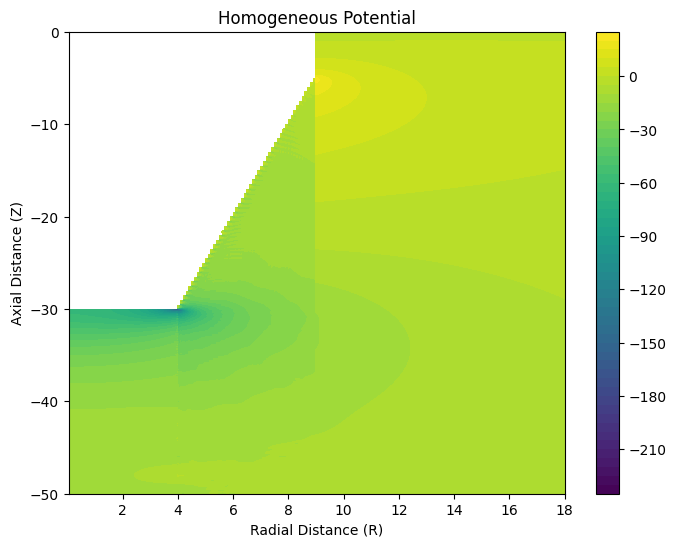

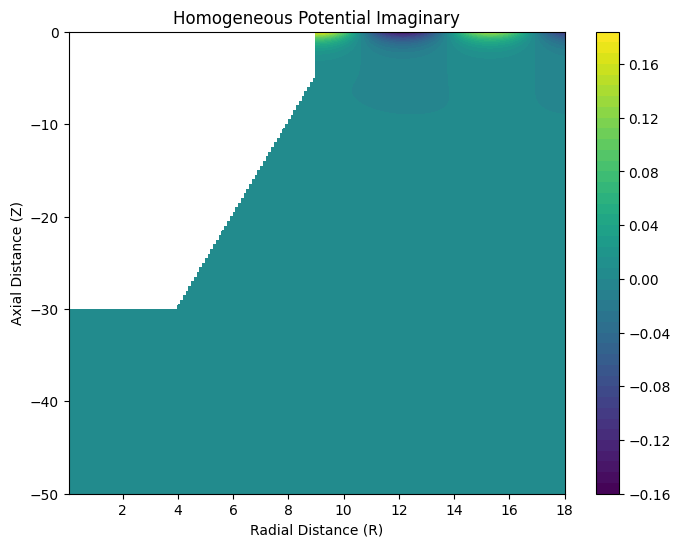

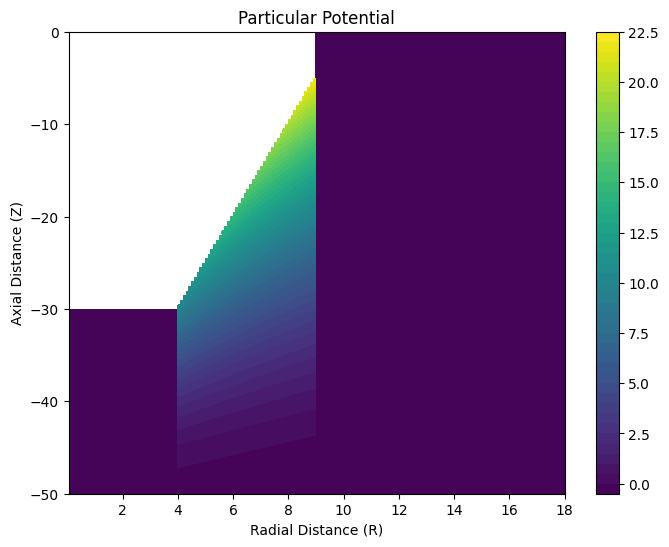

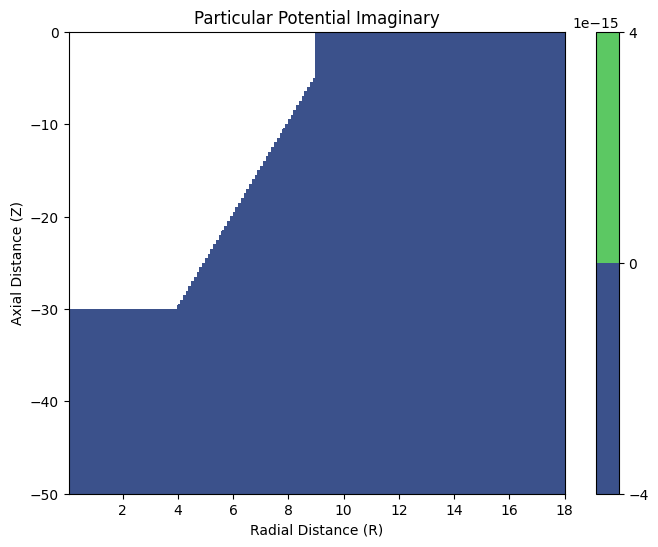

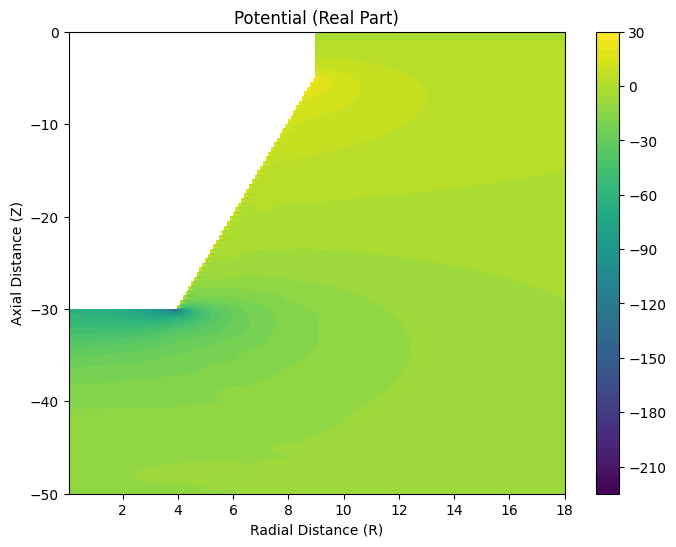

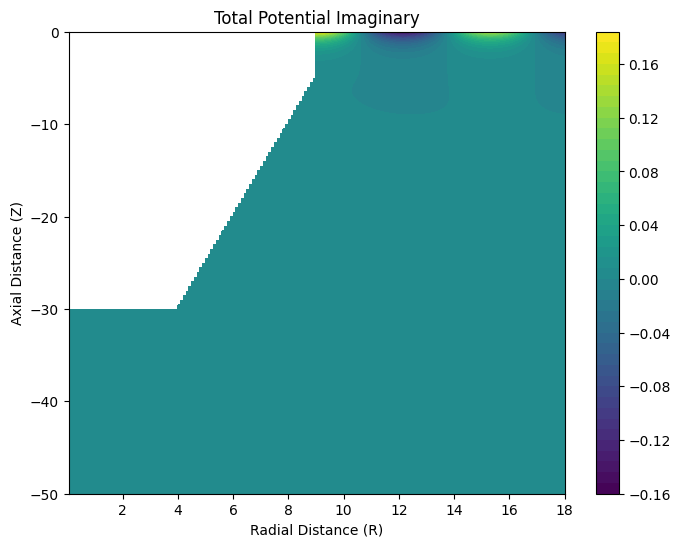

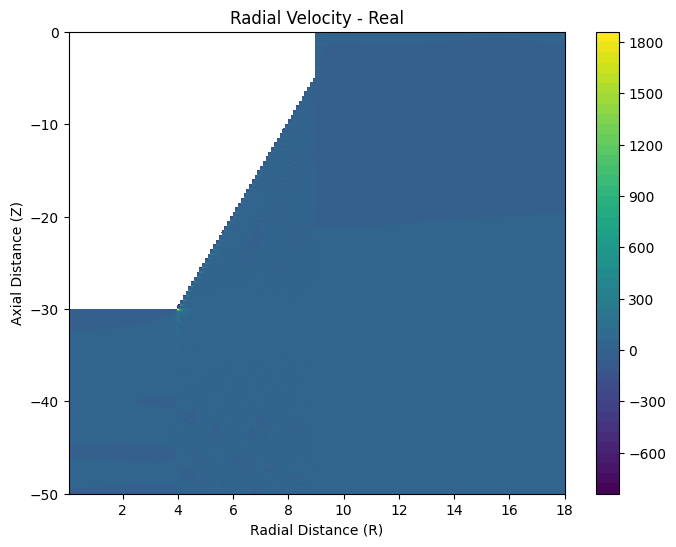

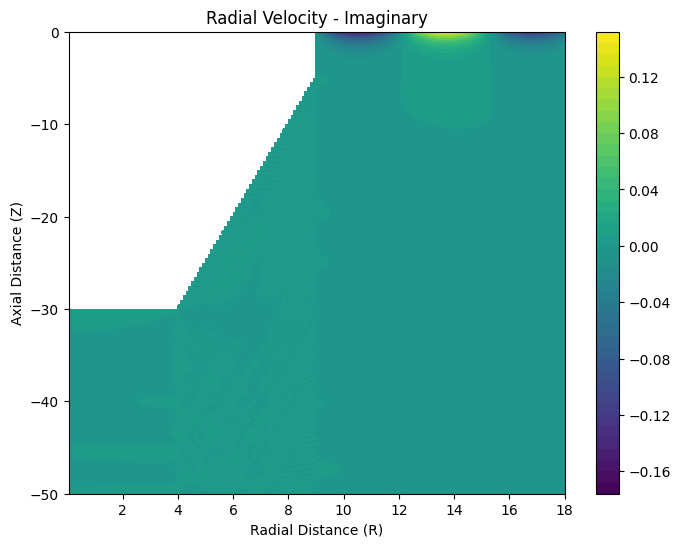

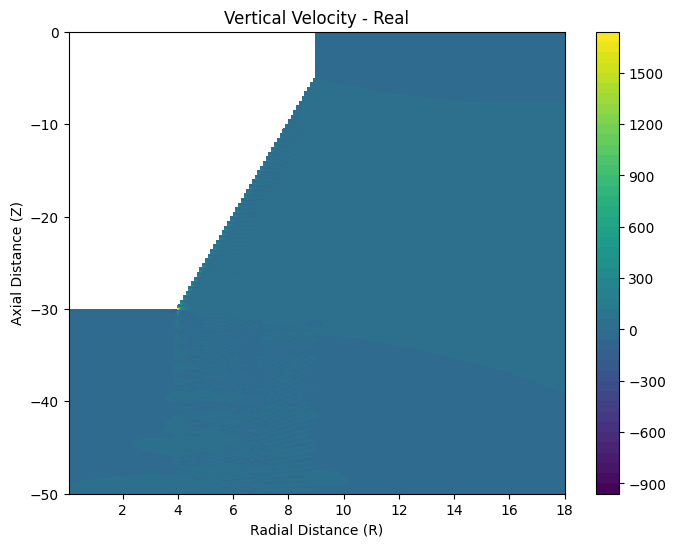

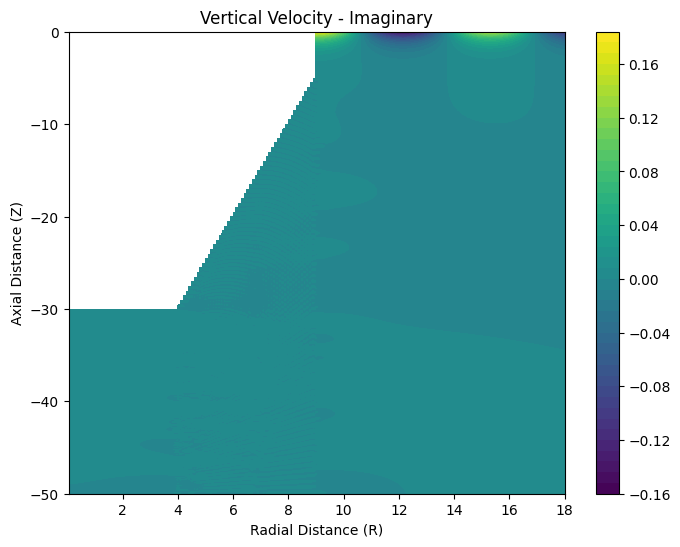

In [ ]:
# plot_both(prob1, cs1)

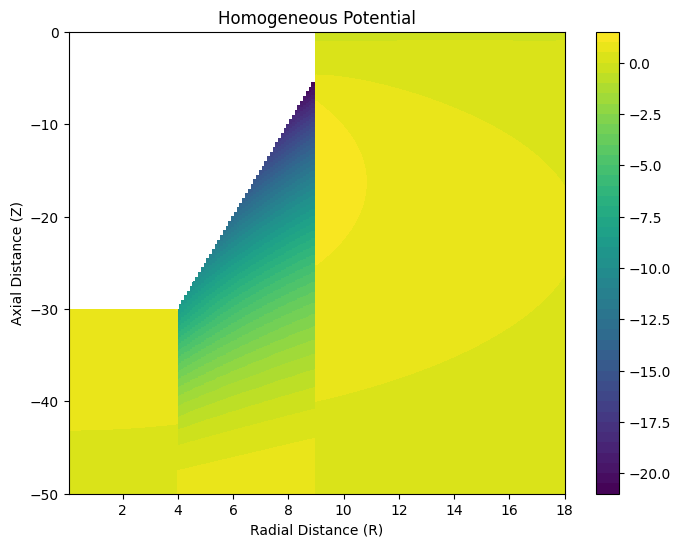

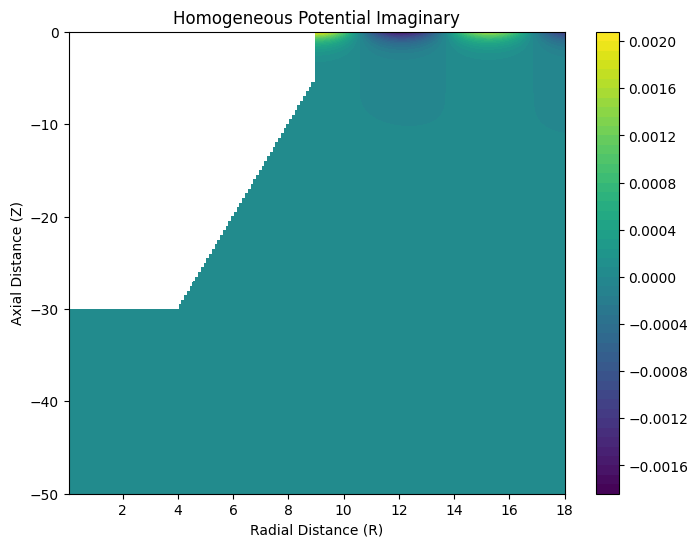

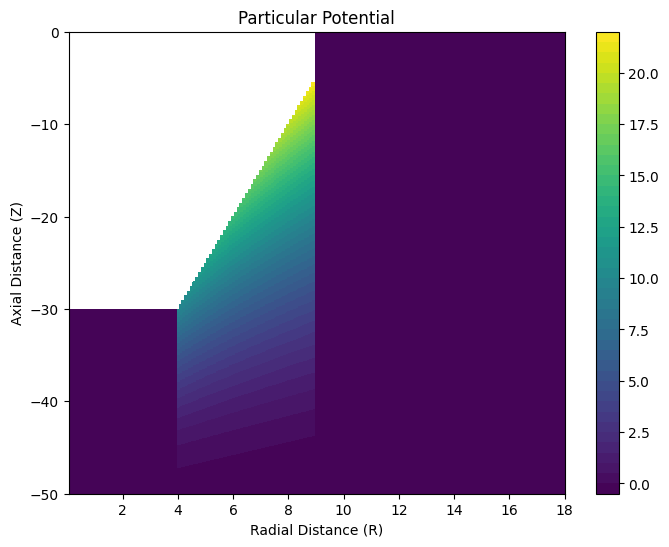

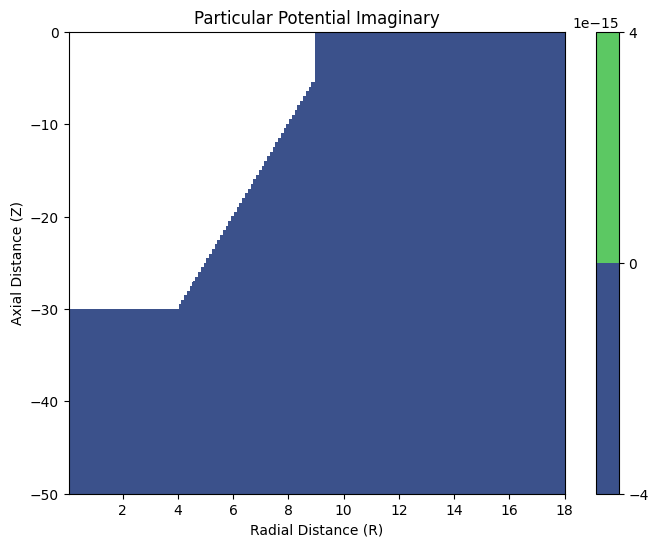

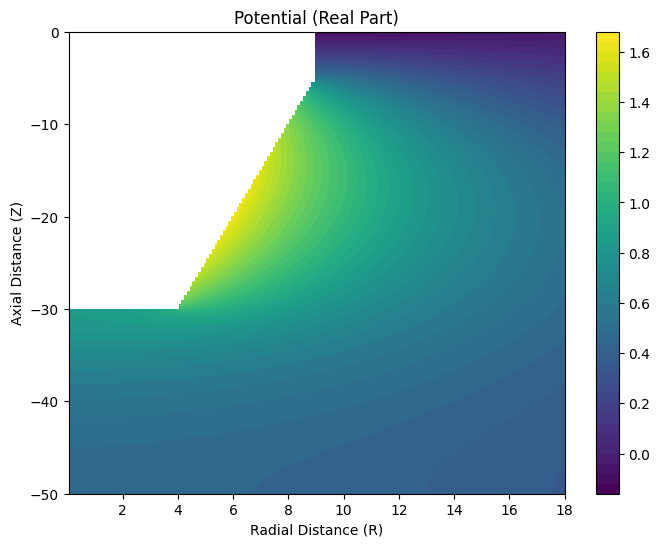

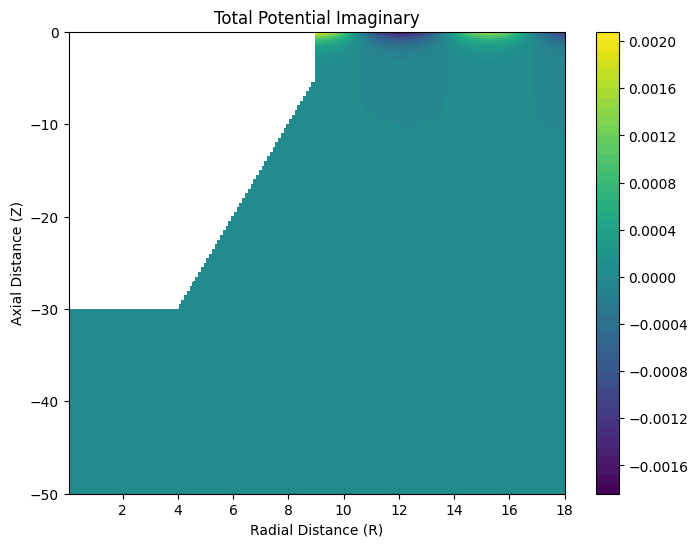

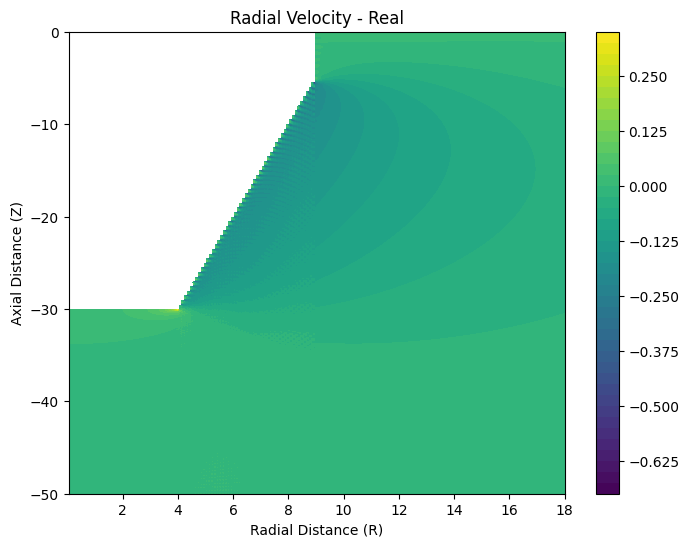

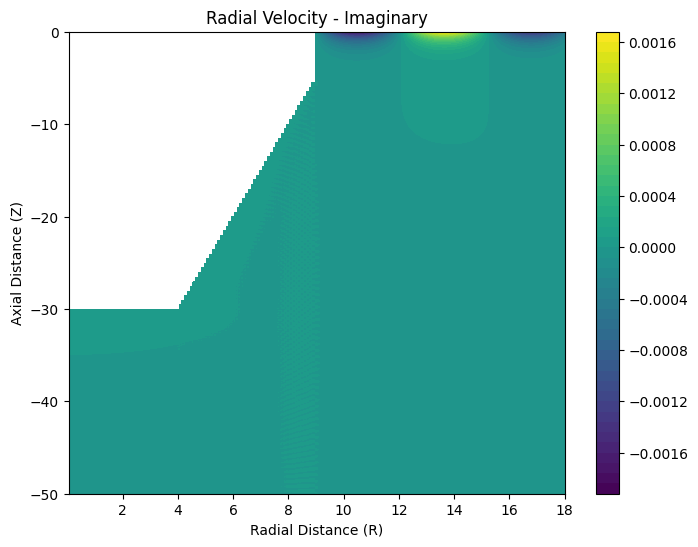

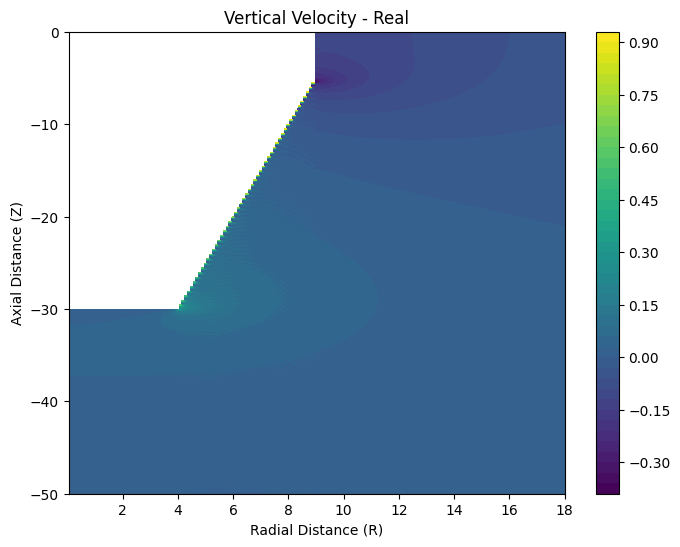

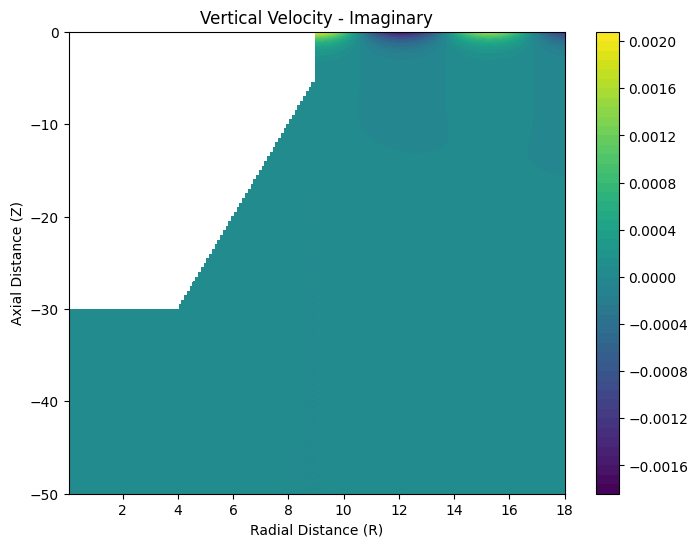

In [6]:
plot_both(prob2, cs2)

In [ ]:
# plot_both(prob3, cs3)

In [5]:
def outline_function(r):
  region = 0
  for rad in a:
    if r <= rad: break
    else: region += 1
  if region == len(a): return 0
  elif d_in[region] == d_out[region]:
    return - d_in[region]
  else:
    inner_rad = 0 if region == 0 else a[region - 1]
    outer_rad = a[region]
    slope = (d_in[region] - d_out[region])/(outer_rad - inner_rad)
    return slope * (r - inner_rad) - d_in[region]

In [ ]:
class SProblem2(SProblem1):
  def phi_p_i(self, r, z, i): # particular solution
      return (1 / (2* (self.h - self.d[i]))) * ((z + self.h) ** 2 - (r**2) / 2)
  
  def potential(self, r, z, cs):
    region = self.det_region(r)
    nmk = self.NMK[region]
    nmks = list(range(nmk))
    if region == self.boundary_count: # Outermost
      lambda_vals = np.vectorize(self.Lambda_k, otypes=[complex])(nmks, r)
      z_vals = np.vectorize(self.Z_k_e, otypes=[complex])(nmks, z)
      return np.dot(cs[-1], lambda_vals * z_vals)
    else:
      phi_p = 0 if not self.heaving[region] else self.phi_p_i(r, z, region)
      r1_vals = np.vectorize(self.R_1n, otypes=[complex])(nmks, r, region)
      z_vals = np.vectorize(self.Z_n_i, otypes=[complex])(nmks, z, region)
      phi_h_1 = np.dot(cs[region][:nmk], r1_vals * z_vals)
      if region == 0: # Innermost
        return phi_p + phi_h_1
      else: # Typical region
        r2_vals = np.vectorize(self.R_2n, otypes=[complex])(nmks, r, region)
        phi_h_2 = np.dot(cs[region][nmk:], r2_vals * z_vals)
        return phi_p + phi_h_1 + phi_h_2
    
  def regional_value(self, i, cs, outline_function, frac1, frac2 = None):
    inner_rad = 0 if i == 0 else self.a[i - 1]
    outer_rad = self.a[i]
    rad1 = frac1 * (outer_rad - inner_rad) + inner_rad
    p1 = self.potential(rad1, outline_function(rad1), cs)
    if frac2 is None:
      return p1 * (outer_rad **2 - inner_rad **2)/2
    else:
      rad2 = frac2 * (outer_rad - inner_rad) + inner_rad
      p2 = self.potential(rad2, outline_function(rad2), cs)
      mid_rad = inner_rad + (outer_rad - inner_rad)/2
      v1 = p1 * (mid_rad **2 - inner_rad **2)/2
      v2 = p2 * (outer_rad **2 - mid_rad **2)/2
      return v1 + v2

  # Compute hydro-coefficients by approximating potential on each surface as equal the potential at a specific point
  # a fraction of the way along that surface
  def hydros_by_averages(self, cs, outline_function, convention, frac1 = 0.25, frac2 = None):
    accumulator = 0
    for region in range(self.boundary_count):
      if self.heaving[region]:
        if self.slopes[region] == 0: # typical calculation
          nmk = self.NMK[region]
          r1 = np.dot([self.int_R_1n(region, m)* self.z_n_d(m) for m in range(nmk)], cs[region][:nmk])
          if region == 0:
            accumulator += (r1 + self.int_phi_p_i(region))
          else:
            r2 = np.dot([self.int_R_2n(region, m)* self.z_n_d(m) for m in range(nmk)], cs[region][nmk:])
            accumulator += (r1 + r2 + self.int_phi_p_i(region))
        else:
          accumulator += self.regional_value(region, cs, outline_function, frac1, frac2)

    hydro_coef = 2 * pi * accumulator
    if convention == "nondimensional":
        # find maximum heaving radius
        max_rad = self.a[0]
        for i in range(self.boundary_count - 1, 0, -1):
            if self.heaving[i]:
                max_rad = self.a[i]
                break
        hydro_coef_nondim = self.h**3/(max_rad**3 * pi)*hydro_coef
        added_mass = hydro_coef_nondim.real
        damping = hydro_coef_nondim.imag
    elif convention == "umerc":
        added_mass = hydro_coef.real * self.h**3 * self.rho
        damping = hydro_coef.imag * self.angular_freq(self.m0) * self.h**3 * self.rho
    elif convention == "capytaine":
        added_mass = hydro_coef.real * self.rho
        damping = hydro_coef.imag * self.angular_freq(self.m0) * self.rho
    else:
        raise ValueError("Allowed conventions are nondimensional, umerc, and capytaine.")
    return added_mass, damping
    

In [93]:
def construct_problem(prob_style, h, a, d_in, d_out, heaving, m0, rho, res, version):
  NMK = [150, 150, 150]
  d_prime, a_prime, heaving_prime, NMK_prime, slopes = slant_approx_vars(a, d_in, d_out, heaving, NMK, res, version)
  prob = prob_style(h, d_prime, a_prime, heaving_prime, NMK_prime, m0, rho, slopes)
  return prob

prob_h = construct_problem(SProblem2, h, a, d_in, d_out, heaving, m0, rho, 50, 2)

In [95]:
for frac1 in [entry / 20 for entry in range(1, 20)]:
  am, dp = prob_h.hydros_by_averages(cs2, outline_function, "capytaine", frac1)
  print(am, dp)

286440.7938975735 0.34829921553666404
287027.9825144714 0.3546401634699884
287896.8969343638 0.36057523789643886
289080.9640090567 0.3660217222609778
290629.96403423697 0.37089600947244455
292607.4440091775 0.37511535887687086
295086.488928708 0.37860008823264923
298144.22384726244 0.3812761455682547
301855.4395080893 0.38307796699864194
306285.7832627302 0.38395149044858473
311485.04048452404 0.3838571645224978
317481.1283501873 0.38277276916720065
324275.49116139725 0.38069585273429407
331840.5737401924 0.37764559050411667
340119.91555099277 0.3736638838962818
349031.1376375827 0.3688155477498631
358471.70866700646 0.3631874744450307
368326.9352258102 0.3568867164110948
378479.2136813938 0.35003748987574174


In [7]:
def plot_contour(prob, cs, r_min, r_max, z_min, z_max, res = 50):
    # Generate grid
    r = np.linspace(r_min, r_max, res)
    z = np.linspace(z_min, z_max, res)
    R, Z = np.meshgrid(r, z)

    # Evaluate function
    def wrapper(r, z):
        if z > outline_function(r):
            return np.nan + 1j * np.nan
        else: return prob.potential(r, z, cs)
    vals = np.vectorize(wrapper, otypes=[complex])(R, Z)

    # Plot contour
    plt.figure(figsize=(6, 5))
    contour = plt.contourf(R, Z, np.real(vals), cmap='viridis', levels = 50)
    plt.colorbar(contour, label='Function value')
    plt.xlabel('r')
    plt.ylabel('z')
    plt.title('Contour Map')
    plt.show()

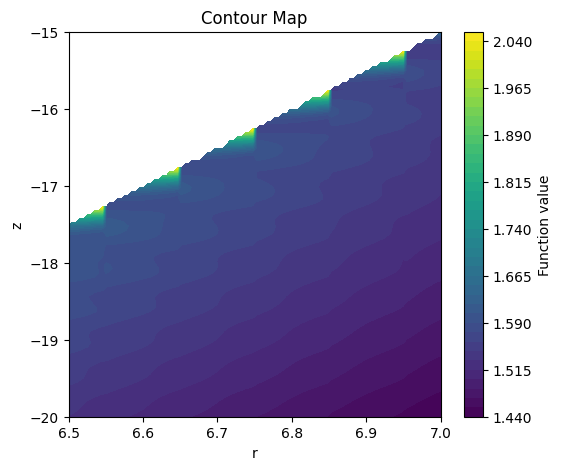

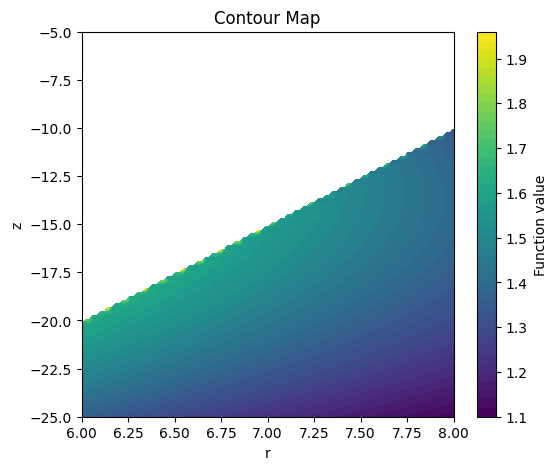

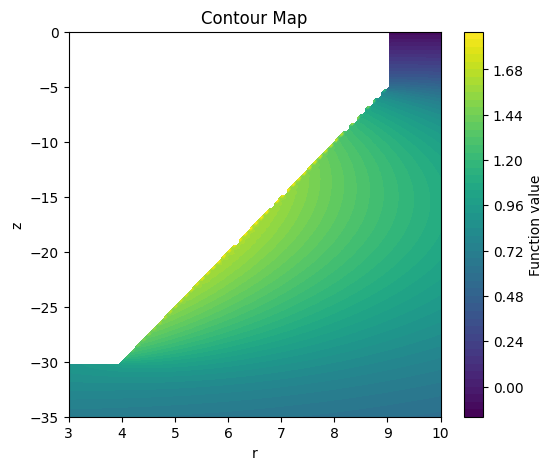

In [97]:
plot_contour(prob_h, cs2, 6.5, 7, -20, -15, res = 100)
plot_contour(prob_h, cs2, 6, 8, -25, -5, res = 100)
plot_contour(prob_h, cs2, 3, 10, -35, 0, res = 140)

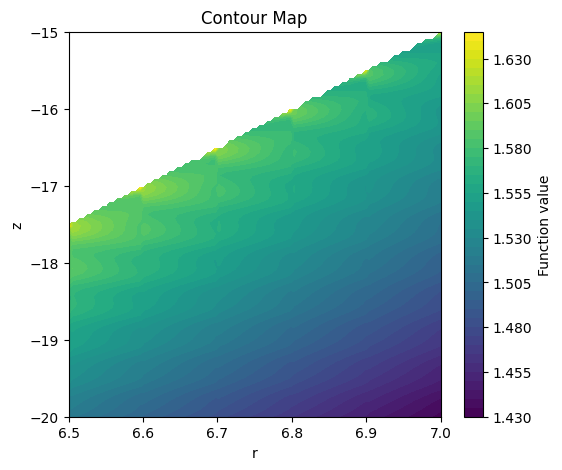

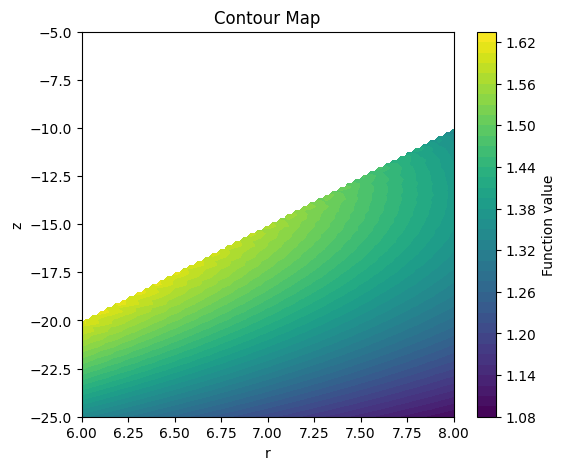

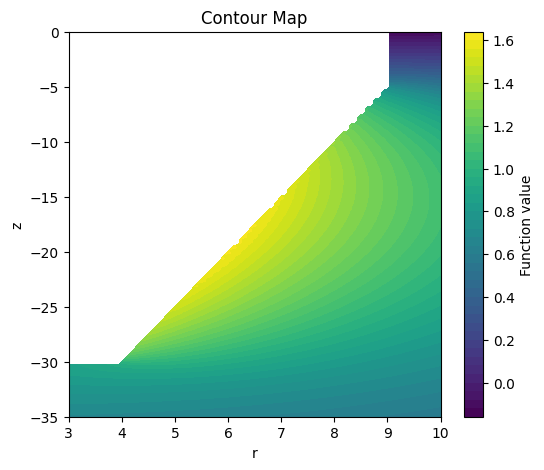

In [101]:
x1, cs1, prob1 = solve_problem(SProblem2, h, a, d_in, d_out, heaving, m0, rho, 50, 1)
plot_contour(prob1, cs1, 6.5, 7, -20, -15, res = 100)
plot_contour(prob1, cs1, 6, 8, -25, -5, res = 100)
plot_contour(prob1, cs1, 3, 10, -35, 0, res = 140)

In [102]:
for frac1 in [entry / 20 for entry in range(1, 20)]:
  am, dp = prob1.hydros_by_averages(cs1, outline_function, "capytaine", frac1)
  print(am, dp)

294385.4915393836 0.7727776041093097
293345.40880530246 0.7895202646838139
292320.6394792255 0.8068873365139563
291370.0321145159 0.8248264180015163
290537.4389449375 0.8432716954187746
289850.5810382452 0.8621414718125315
289322.2386747288 0.8813352699091758
288953.4123605581 0.9007307809146109
288737.99143766554 0.9201809917587576
288668.42972226674 0.9395118621243786
288741.92356672615 0.9585209358439017
288966.5793278531 0.976977256558796
289367.0205318947 0.9946229138778386
289988.8206288502 1.0111764740259477
290901.08351456554 1.0263384500489934
292196.4815427366 1.0397988445880457
293988.15818032087 1.051246658389606
296403.15668361285 1.06038110724567
299572.4618234674 1.0669241378967815


In [8]:
for res in [10, 20, 30, 40]:
  x, cs, prob = solve_problem(SProblem2, h, a, d_in, d_out, heaving, m0, rho, res, 1, nmk = 150)
  print("res =", res)
  for frac1 in [entry / 20 for entry in range(1, 20)]:
    am, dp = prob.hydros_by_averages(cs, outline_function, "capytaine", frac1)
    print(am, dp)

res = 10
298144.5675223318 0.8104398307556231
287124.790419663 0.8835518215859062
281652.82475273113 0.9551537356826465
278562.7791610741 1.0276256102753631
276296.7849596891 1.104305336476299
274767.58489152516 1.1866346165869683
274102.27072352194 1.2751833363522127
274253.86659650964 1.3708004065362906
275095.00213219645 1.473545448172108
276574.6285691076 1.5818848251173712
278724.9728131093 1.6953385918233634
281547.8669614459 1.8178942564169216
284950.7096162185 1.9551077872366864
288860.0036257118 2.1050567285068356
293458.88387292845 2.257026356584596
299070.9124042913 2.4093619196593656
305393.32497628214 2.588664734616018
310597.66112832667 2.829219583685838
313082.2422695127 3.105415043813165
res = 20
297618.4226122961 0.7929109876107215
292276.596286892 0.836639184862656
288150.16323791386 0.8816344493595446
285469.64885153575 0.9271522303914156
283975.04171942873 0.972971656843099
283271.4485266613 1.0191780703523117
283054.41920269304 1.0658759243834843
283169.1159117049 

In [108]:
x, cs, prob = solve_problem(SProblem2, h, a, d_in, d_out, heaving, m0, rho, 50, 1, nmk = 100)
for frac1 in [entry / 20 for entry in range(1, 20)]:
  am, dp = prob.hydros_by_averages(cs, outline_function, "capytaine", frac1)
  print(am, dp)

293364.5723015009 0.7539706163429731
292529.40695860016 0.7716478696512223
291679.45338094205 0.7895351442754892
290844.51310949423 0.8075202085668527
290055.22279149573 0.8254832041133934
289342.7328216264 0.8432978065162124
288738.6520573806 0.8608324722103364
288275.2411591984 0.8779517642857063
287985.8069849097 0.8945177507653704
287905.22359016084 0.910391468924836
288070.4842226482 0.925434448909474
288521.1754482372 0.9395102890720033
289299.7609535899 0.952486274086819
290451.56973539136 0.9642350250123387
292024.40161316225 0.9746361681122628
294067.6916728123 0.9835780064929374
296631.21276214474 0.9909591755826815
299763.33895392466 0.996690260317288
303508.9395482078 1.0006953487771504


In [105]:
x, cs, prob = solve_problem(SProblem2, h, a, d_in, d_out, heaving, m0, rho, 50, 1, nmk = 200)
for frac1 in [entry / 20 for entry in range(1, 20)]:
  am, dp = prob.hydros_by_averages(cs, outline_function, "capytaine", frac1)
  print(am, dp)

294400.8007501648 0.7844820981840104
292954.51298705494 0.8015627185177292
291624.6930467523 0.8189976115995038
290513.54384685913 0.8366821228246973
289677.16040001856 0.8545474408003974
289129.0122389183 0.8725628318936532
288849.6797486107 0.8907309161384247
288799.11598129687 0.9090760132763818
288928.28867365554 0.9276263450626546
289188.4314277555 0.9463916328223229
289537.79388620984 0.9653383121402079
289947.18066026154 0.9843651273494228
290406.2162581989 1.0032821946691064
290931.8475768223 1.0217966699231233
291579.07589005004 1.0395078770285247
292451.6786151666 1.0559141242420753
293708.5247995408 1.070432466323164
295560.03369650344 1.0824314107828086
298250.2907113095 1.0912751065646733


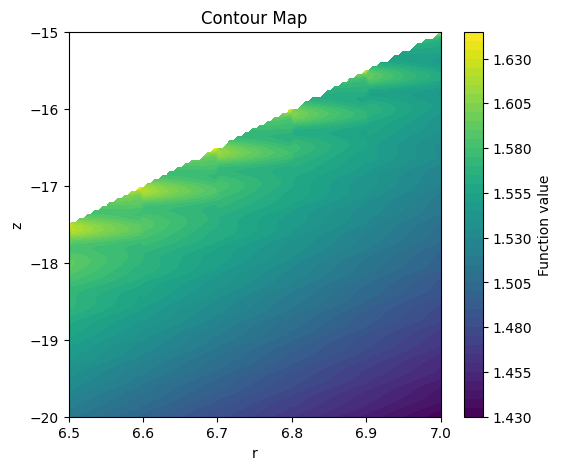

In [106]:
plot_contour(prob, cs, 6.5, 7, -20, -15, res = 100)

In [ ]:
# This formulation appears to give a correct macroscopic potential
# It's convergence via slant resolution should be compared to regular MEEM, to see if it converges faster

resolutions = list(range(5, 55, 5))
xs, css, probs = [], [], []
ams_lst, dps_lst = [], []
for res in resolutions:
  x, cs, prob = solve_problem(SProblem2, h, a, d_in, d_out, heaving, m0, rho, res, 1)
  ams, dps = [], []
  for frac1 in [entry / 20 for entry in range(1, 20)]:
    am, dp = prob.hydros_by_averages(cs, outline_function, "capytaine", frac1)
    ams.append(am)
    dps.append(dp)
  ams_lst.append(ams)
  dps_lst.append(dps)
  xs.append(x)
  css.append(css)
  probs.append(prob)